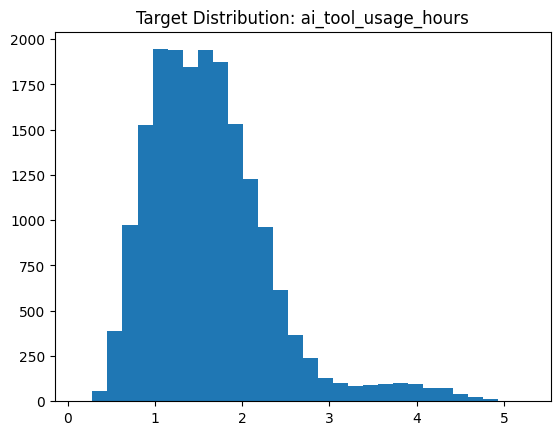

Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.693289	valid_1's rmse: 0.688406
Early stopping, best iteration is:
[25]	training's rmse: 0.700814	valid_1's rmse: 0.688255
✅ Validation R² Score (LightGBM): 0.0002712851771377034


PermissionError: [Errno 13] Permission denied: 'final_submission.csv'

In [10]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import lightgbm as lgb
import matplotlib.pyplot as plt

# 2. Load Data
train = pd.read_csv("Dataset/train.csv")
test = pd.read_csv("Dataset/test.csv")
submission = pd.read_csv("Dataset/submission.csv")

# 3. Preprocessing
train.dropna(subset=['ai_tool_usage_hours'], inplace=True)
train.fillna(train.mean(numeric_only=True), inplace=True)
test.fillna(test.mean(numeric_only=True), inplace=True)

# 4. Combine train + test for encoding consistency
train['source'] = 'train'
test['source'] = 'test'
test['ai_tool_usage_hours'] = 0  # placeholder

full_data = pd.concat([train, test], axis=0)

# 5. One-hot encode categorical features
full_data = pd.get_dummies(full_data)

# 6. Split back into train and test
train = full_data[full_data['source_train'] == 1].drop(columns=['source_train', 'source_test'])
test = full_data[full_data['source_test'] == 1].drop(columns=['source_train', 'source_test', 'ai_tool_usage_hours'])

# 7. Separate features and target
X = train.drop(columns=['ai_tool_usage_hours'])
y = train['ai_tool_usage_hours']
X_test = test

# 8. Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Optional: Visualize target distribution
plt.hist(y, bins=30)
plt.title('Target Distribution: ai_tool_usage_hours')
plt.show()

# 9. Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 10. Prepare LightGBM dataset
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

# 11. LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': 7,
    'verbose': -1,
    'seed': 42
}

# 12. Train model with early stopping and logging callbacks
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)  # logs metrics every 50 rounds
    ]
)

# 13. Validate
y_pred = model.predict(X_val, num_iteration=model.best_iteration)
print("✅ Validation R² Score (LightGBM):", r2_score(y_val, y_pred))

# 14. Train on full data
lgb_full = lgb.Dataset(X_scaled, label=y)
model_full = lgb.train(params, lgb_full, num_boost_round=model.best_iteration)

# 15. Predict on test set
test_preds = model_full.predict(X_test_scaled)

# 16. Save submission
submission['ai_tool_usage_hours'] = test_preds
submission.to_csv("final_submission.csv", index=False)
print("✅ final_submission.csv generated successfully!")

# 17. Feature importance plot
lgb.plot_importance(model_full, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances")
plt.show()
